# Introduction

## Multivariable Regression vs Principal Component Regression

1. **In Multivariable regression, we simply have a set of inputs, assume they are independent and fit a function to all inputs.**

<img src="Slide1.png" width="500" />

2. **Knowing what you know about PCA, what do you think Principal Component Regression will look like?**

<img src="Slide2.png" width="500" />

In Figure above: 
 1. **What is N?** Samples <br>
 2. **What is K?** Original Dimensions<br>
 3. **What is T matrix?** Transformed data in reduced dimensions (SCORE MATRIX) <br>
 4. **What is A???** number of PCS <br>
 
**REMEMBER WHAT PCA DOES:** <br><br>

<img src="Slide3.png" width="500" />

## Cheddar Cheese Tasting Example

**Problem**: A data set has been collected to optimize the taste of aged cheddar cheese. <br>
The three attributes that have been measured are: <br>

1. Acetic Acid, <br>
2. Lactic Acid, <br>
3. $H_2S$ <br>

The **output** that was measured is: 

1. Taste <br>

30 samples were collected.

The data can be found in **cheddar-cheese.xlsx**.

**Discussion:** Before we do any analysis, let's think: <br>
1. Was this data set designed by a Design of Experiments? <br>
2. Do we have enough data? <br>

      Acetic        H2S    Lactic  Taste
1   4.497505   3.123985  1.061236  12.30
2   5.204935   5.054121  1.326818  20.90
3   5.405840   5.447646  1.393778  39.00
4   5.807098   7.507645  1.597249  47.90
5   4.631679   3.799417  1.128540   5.60
6   5.592451   7.575687  1.552447  25.90
7   5.807684   8.705586  1.662952  37.30
8   6.098679   7.971007  1.688532  21.90
9   4.919122   3.855114  1.196573  18.10
10  5.304836   4.189213  1.302061  21.00
11  5.777033   6.150966  1.516193  34.90
12  6.475253   7.915083  1.770605  57.20
13  4.479232   2.996540  1.050129   0.70
14  5.230058   4.940561  1.326282  25.90
15  6.126628   6.746099  1.627804  54.90
16  6.344143   9.582950  1.832257  40.90
17  4.784895   3.911490  1.169313  15.90
18  5.441115   4.707049  1.361215   6.40
19  5.296838   6.186066  1.409553  18.00
20  5.521860   9.084304  1.619064  38.90
21  4.558389   4.947641  1.174820  14.00
22  5.292223   5.218601  1.355554  15.20
23  5.417986   9.233039  1.603721  32.00
24  5.907461  10

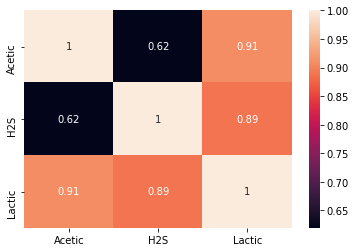

In [190]:
from pylab import *
from sklearn import preprocessing
import seaborn as sns
# load data using pandas:
import pandas
cc = pandas.read_excel('cheddar-cheese2.xlsx')
cc.index = cc.index + 1 # just so that sample number starts from 1 and not 0
print(cc)

rname=list(str(i) for i in cc.index)
#print(rname)

#which columns are x and y data:
yinst = ['Taste']
xinst = ['Acetic','H2S','Lactic']

#create sub-dataframes with input-output:
y = cc[yinst].values
x = cc[xinst].values

#store original data mean and std for transformations later:
xmean = x.mean(0)
ymean = y.mean()
xstd = x.std(0)
ystd = y.std()

#Transform data - zscore:
scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)
y = scaler.fit_transform(y)

print(x)

### MAKING DICTIONARIES FOR PYTHON:
ydic={}
for j in yinst:
    for i in rname:
        ydic[(i,j)]=float((y[int(i)-1]))

xdic={}
for j in range(len(xinst)):
    for i in rname:
        xdic[(i,xinst[j])]=x[int(i)-1,j]
        
        
%matplotlib inline
xcorr=cc.iloc[:,:3]
corr_matrix = xcorr.corr()
sns.heatmap(corr_matrix,annot=True)
show()

### Approach 1: multivariable regression

We can assume all inputs are important and independent and fit a 3-dimensional regression function. <br>
Using our codes from fitting functions using Pyomo from the past:


<ipython-input-169-040dc2472e74>:17: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return (model.b0 + sum((model.bl[j]*model.xs[i,j]) for j in model.n)  + sum((model.bs[j]*model.xs[i,j]**2) for j in model.n))  - model.ypred[i] == 0
<ipython-input-169-040dc2472e74>:21: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return sum((model.ypred[i]-model.yact[i,j])**2 for i in model.s for j in model.yn)


objective function = 0.38898874170316317
parameter values: 0.029609866240745096 -1781836.2517495537 -1612686.0818627914 3055604.743125121 -0.21623962851348155 -0.21646154157303307 0.4030913088154447


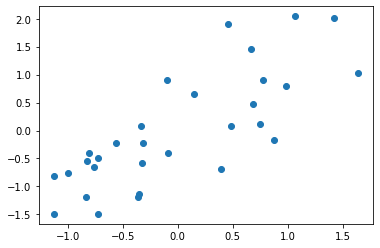

In [169]:
from pyomo.environ import *
model = ConcreteModel()

#Define Data:
model.n = xinst 
model.yn = yinst
model.s = rname
model.yact = ydic
model.xs = xdic

model.ypred = Var(model.s)
model.b0 = Var() #constant term
model.bl = Var(model.n) #linear terms
model.bs = Var(model.n) #square terms

def con_rule(model,i): # postulated function is: y= b0 + sum_n bl_n*x_n + sum_n bs_n*x_n**2
    return (model.b0 + sum((model.bl[j]*model.xs[i,j]) for j in model.n)  + sum((model.bs[j]*model.xs[i,j]**2) for j in model.n))  - model.ypred[i] == 0
model.con = Constraint(model.s, rule=con_rule)

def obj_rule(model):
    return sum((model.ypred[i]-model.yact[i,j])**2 for i in model.s for j in model.yn)
model.obj = Objective(rule=obj_rule) #Instead of defining the objective as we did above, we now set it equal to the rule.

#same as above:
solver = SolverFactory('ipopt')
solver.solve(model)
print('objective function =', value(model.obj)/30)
#model.pprint()

#STORING VALUES OF PARAMETERS. SHOULD DO THIS MORE EFFICIENTLY, I AM DOING IT TO HELP YOU UNDERSTAND MODEL:
c0 = value(model.b0)

cl1 = value(model.bl['Acetic'])
cl2 = value(model.bl['H2S'])
cl3 = value(model.bl['Lactic'])

cs1 = value(model.bs['Acetic'])
cs2 = value(model.bs['H2S'])
cs3 = value(model.bs['Lactic'])
print('parameter values:',c0,cl1,cl2,cl3,cs1,cs2,cs3)

def bbf(xv):
    return c0 + cl1*xv[:,0]+cl2*xv[:,1]+cl3*xv[:,2]+cs1*xv[:,0]**2+cs2*xv[:,1]**2+cs3*xv[:,2]**2

#print(bbf(x))

%matplotlib inline
fig,ax = subplots()
scatter(bbf(x),y)
#xlim(min(y.min(),bbf(x).min())-0.1,max(y.max(),bbf(x).max())+0.1)
##ylim(min(y.min(),bbf(x).min())-0.1,max(y.max(),bbf(x).max())+0.1)
#ax.set_aspect('equal')
show()

### IS THIS A GOOD MODEL????

1. Not that great, not that bad either.
2. Scatter plot shows some trend is captured, but not perfect.
3. There is probably a better fit to this data.

In [170]:
#HERE WE OPTIMIZE FUNCTION!!!
from pyomo.environ import *
model2 = ConcreteModel()

#Define Variables:
model2.n = xinst
lb = {'Acetic':min(x[:,0]), 'H2S':min(x[:,1]),'Lactic':min(x[:,2])}
ub = {'Acetic':max(x[:,0]), 'H2S':max(x[:,1]),'Lactic':max(x[:,2])}
def fb(model, i):
    return (lb[i], ub[i])
model2.x = Var(model2.n,bounds=fb)

def obj_rule(model2): 
    return -(c0 + cl1* model2.x['Acetic'] + cl2*model2.x['H2S'] + cl3*model2.x['Lactic'] + cs1*model2.x['Acetic']**2 + cs2*model2.x['H2S']**2 + cs3*model2.x['Lactic']**2) 
model2.obj = Objective(rule=obj_rule)

#same as above:
solver = SolverFactory('ipopt')
solver.solve(model2)
print('maximum predicted taste:',(value(-model2.obj))*ystd+ymean)
print('optimal value of Acetic Acid:',(value(model2.x['Acetic']))*xstd[0]+xmean[0])
print('optimal value of H2S:',value(model2.x['H2S'])*xstd[1]+xmean[1])
print('optimal value of Lactic Acid:',value(model2.x['Lactic'])*xstd[2]+xmean[2])

model2.pprint()


maximum predicted taste: 176129739.21900174
optimal value of Acetic Acid: 4.4792317
optimal value of H2S: 2.99654032
optimal value of Lactic Acid: 1.83225702
1 Set Declarations
    x_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'Acetic', 'H2S', 'Lactic'}

1 Var Declarations
    x : Size=3, Index=x_index
        Key    : Lower               : Value               : Upper              : Fixed : Stale : Domain
        Acetic : -1.8212904105387495 : -1.8212904105387495 : 1.7469554661486624 : False : False :  Reals
           H2S : -1.4084572849099444 : -1.4084572849099444 :  2.041955436011475 : False : False :  Reals
        Lactic :  -1.805417429650564 :  1.8010473427060631 : 1.8010473427060631 : False : False :  Reals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : - (0.029609866240745096 - 1781836.2517

### Approach 2: PCA first, then Regression (=Principal Component Regression)

Since our data set was not carefully designed, we could first check to see whether our inputs are correlated, <br>
or whether they can be reduced into lower dimensional transformed subspaces.

In [171]:
from pylab import *
%matplotlib inline
from sklearn import decomposition
import seaborn as sns
#create a PCA structure, with up to 2 Principal Components:
xarr = x
yarr = y 
pca = decomposition.PCA(n_components=2)
pc = pca.fit_transform(x)
mu = np.mean(x, axis=0)

#Create a DataFrame variable to pass on to 
pc_df = pandas.DataFrame(data = pc , columns = ['PC1','PC2'])
pc_df.head()

#Create a DataFrame variable with information about the explained variance:
df = pandas.DataFrame({'var':pca.explained_variance_ratio_,'PC':['PC1','PC2']})

#Transformed data in 2D (scores):
print(pc)

#Create pc dictionary:
keys1 = ['1','2']
keys2 = rname
pcdic={}
for j in keys1:
    for i in keys2:
        pcdic[(i,j)]=pc[int(i)-1,int(j)-1]
#print(pcdic)

[[-2.8287667  -0.30043564]
 [-0.85481789 -0.06686223]
 [-0.35923846  0.05204838]
 [ 1.16620672 -0.14368083]
 [-2.32431609 -0.36132839]
 [ 0.84210539 -0.43682964]
 [ 1.6708256  -0.55029372]
 [ 1.8401472   0.06554657]
 [-1.82857214 -0.01868383]
 [-1.05429801  0.35291125]
 [ 0.54640857  0.27982685]
 [ 2.43542361  0.55826892]
 [-2.91237611 -0.28008598]
 [-0.86127949  0.00335656]
 [ 1.37107968  0.51722448]
 [ 2.92121208 -0.17380402]
 [-2.02543238 -0.20670321]
 [-0.61264625  0.34825637]
 [-0.2278931  -0.3361627 ]
 [ 1.36038449 -1.0386212 ]
 [-1.96199387 -0.84396743]
 [-0.64223301 -0.01298983]
 [ 1.25223173 -1.21986383]
 [ 2.46800397 -0.93692238]
 [-1.16605519  0.61421013]
 [-0.2327258   1.62252188]
 [ 2.00840865  0.86203093]
 [-1.14854959  0.46569356]
 [ 0.63566148  0.01086684]
 [ 0.5230949   1.17447214]]


explained variance per component: [0.87309972 0.12690028]
total explained variance 1.0
loadings or eigenvector values per component: [[ 0.55890429  0.5530937   0.61782955]
 [ 0.69104109 -0.722491    0.02165548]]


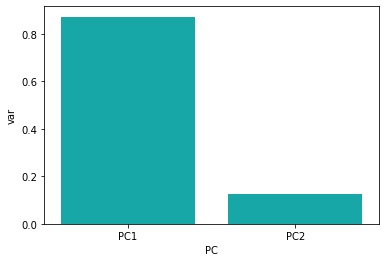

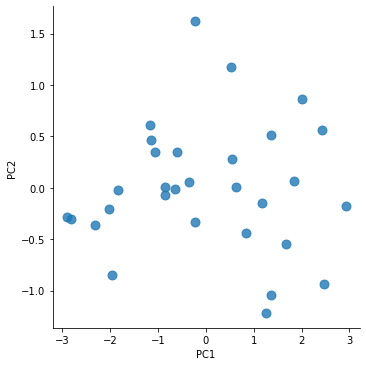

In [147]:
print('explained variance per component:',pca.explained_variance_ratio_)
print('total explained variance',sum(pca.explained_variance_ratio_))
#print loadings or eigenvector coefficients:
loadings = pca.components_
print('loadings or eigenvector values per component:',loadings)


#Create a bar plot of explained variance:
sns.barplot(x='PC',y="var", data=df, color="c")

sns.lmplot( x="PC1", y="PC2",
  data=pc_df, 
  fit_reg=False,     
  legend=True,
  scatter_kws={"s": 80}) # specify the point size
show()


### How can we reconstruct original data set?

**How do I go back to original space????** 

As explained in class: $ T p = X $
- T = $[N \times A]$ <br>
- p = $[A \times K]$ <br>
- X = $[N \times K]$ <br>

**Because the data is centered by subtracting mean by pca decomposition, we also need to add the mean after the matrix multiplication!**

[[-1.78862321 -1.347511   -1.75420174]
 [-0.52396593 -0.42448703 -0.52957969]
 [-0.16481234 -0.23629702 -0.220821  ]
 [ 0.55250858  0.7488297   0.7174055 ]
 [-1.548763   -1.02450808 -1.44385591]
 [ 0.16878908  0.78136867  0.51081784]
 [ 0.55355602  1.32170538  1.02036856]
 [ 1.07376153  0.97041702  1.13831676]
 [-1.0349081  -0.99787284 -1.13015052]
 [-0.3453755  -0.83810079 -0.643734  ]
 [ 0.49876195  0.10004275  0.34364715]
 [ 1.74695546  0.94367319  1.51676626]
 [-1.82129041 -1.40845729 -1.80541743]
 [-0.47905328 -0.47879334 -0.53205123]
 [ 1.12372568  0.3846455   0.85829429]
 [ 1.51257223  1.74127584  1.80104734]
 [-1.27486325 -0.97091269 -1.25584824]
 [-0.10175116 -0.59046287 -0.3709693 ]
 [-0.35967267  0.11682828 -0.14807886]
 [ 0.04259479  1.50281457  0.8179939 ]
 [-1.67978296 -0.47540758 -1.23045431]
 [-0.36792329 -0.34582999 -0.39707183]
 [-0.14309835  1.57394213  0.74724903]
 [ 0.73192614  2.04195544  1.50451628]
 [-0.22726881 -1.08869908 -0.70712234]
 [ 0.99115784 -1.30097663

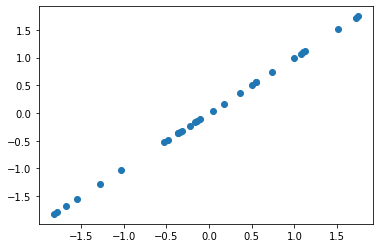

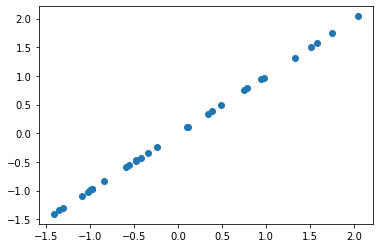

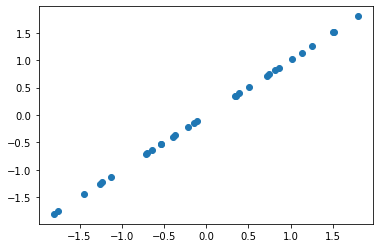

In [172]:
#Reconstructing original data set, where pc=T, loadings = p: 

#Matrix multiplication Tp:
Xhat = np.dot(pc, loadings)
#Adding mean:
Xhat += mu
print(Xhat)
print(pc)
#What does the new reconstruction of X look like as compared to original?
#If we did not lose much variability, should be relatively good correlation: 
## EXTRA PRACTICE: You can try to increase PCs to 3 or reduce PCs to 1, what does the fit below look like???
scatter(Xhat[:,0],x[:,0])
show()

scatter(Xhat[:,1],x[:,1])
show()

scatter(Xhat[:,2],x[:,2])
show()

**GREAT!!!** <br>
**It looks like we lost very little, so the true dimensionality of the data set is 2D.**

**This means that if I optimize with respect to 2 new dimensions and I get a solution:**<br>

$t_1=0.5$ and $t_2= 0.5$ <br>

**What is that with respect to Acetic Acid, H2S, Lactic Acid???** <br>

**We do the same operations as we did above!** <br>

We see that $t_1=0.5$ and $t_2= 0.5$ is equivalent to: <br>

In [174]:
topt = [0.5,0.5]

Xopt = np.dot(topt,loadings)
Xopt +=mu

print(Xopt*xstd+xmean)

[5.84763337 5.76465324 1.51100873]


### How do we do optimization of parameters in reduced dimensions???

In [175]:
#HERE YOU WOULD CREATE A MODEL WITH EITHER 1 or 2 PCS!!!
from pyomo.environ import *
m = ConcreteModel()

#Define Data:
m.n = ['1','2'] #depending on dimension 
m.yn = yinst
m.s = rname
m.yact = ydic
m.xs = pcdic

m.ypred = Var(m.s)
m.b0 = Var() #constant term
m.bl = Var(m.n) #linear terms
m.bs = Var(m.n) #square terms

def con_rule(m,i): # postulated function is: y= b0 + sum_n bl_n*x_n + sum_n bs_n*x_n**2
    return (m.b0 + sum((m.bl[j]*m.xs[i,j]) for j in m.n) + sum((m.bs[j]*m.xs[i,j]**2) for j in m.n))  - m.ypred[i] == 0
m.con1 = Constraint(m.s, rule=con_rule)

def obj_rule(m):
    return sum((m.ypred[i]-m.yact[i,j])**2 for i in m.s for j in m.yn)
m.obj = Objective(rule=obj_rule) #Instead of defining the objective as we did above, we now set it equal to the rule.

#same as above:
solver = SolverFactory('ipopt')
solver.solve(m)
print(value(m.obj)/30)
#m.pprint()


<ipython-input-175-10bdd52bdf1b>:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return (m.b0 + sum((m.bl[j]*m.xs[i,j]) for j in m.n) + sum((m.bs[j]*m.xs[i,j]**2) for j in m.n))  - m.ypred[i] == 0
<ipython-input-175-10bdd52bdf1b>:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return sum((m.ypred[i]-m.yact[i,j])**2 for i in m.s for j in m.yn)


0.3908871552745674


## Optimize black-box function in reduced dimensions:

- Now we have a fit, let's optimize in 2 PC dimensions, and convert back to original! <br> <br>
**Discussion:** <br>
- Is the fit better or worse???
  - It is slightly worse with respect to Mean Squared Error (objective), but we transformed it into 2 dimensions.
  - The fitted vs predicted looks very similar. Some would consider this a success (basically similar model with one less dimension). 
  - It is hard to see the benefit here, because original problem is low dimensional anyway, but imagine if you go from 1000 dimensions to 10, without losing much accuracy!!!
  - The 'badness' of the fit may also be because the function we assumed (linear + quadratic terms), is just not a good fit for the data. Other nonlinear models may be selected!
  

0.015441548761156897 0.47200113730876675 -0.2811612480349001 0.024754312774165347 -0.21087554433615263
[-1.05622059 -0.35208882 -0.16613007  0.63560339 -0.87384446  0.51305083
  0.96404198  0.94847958 -0.75969662 -0.58016154  0.18554905  1.08910328
 -1.0870323  -0.37366665  0.5072902   1.64799427 -0.78990631 -0.38792871
 -0.02015278  0.76789746 -0.72824376 -0.27386626  0.67449453  1.40943658
 -0.75352551 -1.104401    0.66419357 -0.67068778  0.32239662 -0.35197815]


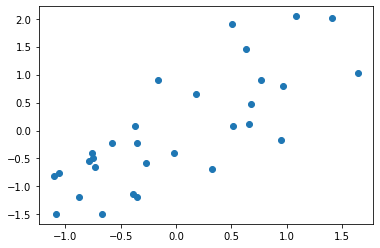

In [176]:
#STORING VALUES OF PARAMETERS.
d0 = value(m.b0)

dl1 = value(m.bl['1'])
dl2 = value(m.bl['2'])

ds1 = value(m.bs['1'])
ds2 = value(m.bs['2'])
print(d0,dl1,dl2,ds1,ds2)

def bbf_red(xv):
    return d0 + dl1*xv[:,0]+dl2*xv[:,1]+ds1*xv[:,0]**2+ds2*xv[:,1]**2

print(bbf_red(pc))

%matplotlib inline

scatter(bbf_red(pc),y)
show()

In [177]:
#HERE WE OPTIMIZE FUNCTION!!!
from pyomo.environ import *
m2 = ConcreteModel()

#Define Variables:
# VERY VERY IMPORTANT HERE: Provide BOUNDS. These bounds must be based on bounds on PC scores (T matrix)
m2.x1 = Var(bounds = (min(pc[:,0]),max(pc[:,0])))
m2.x2 = Var(bounds = (min(pc[:,1]),max(pc[:,1])))

def obj_rule(m2): # postulated function is: y= b0 + sum_n bl_n*x_n + sum_n bs_n*x_n**2
    return -(d0 + dl1* m2.x1 + dl2*m2.x2 + ds1*m2.x1**2 + ds2*m2.x2**2)
m2.obj = Objective(rule=obj_rule)

#same as above:
solver = SolverFactory('ipopt')
solver.solve(m2)
print('maximum predicted taste:',value(-m2.obj)*ystd+ymean)
print('optimal value of t1:',value(m2.x1))
print('optimal value of t2:',value(m2.x2))

m2.pprint()


maximum predicted taste: 51.69195138661482
optimal value of t1: 2.921212077901863
optimal value of t2: -0.6666520893928424
2 Var Declarations
    x1 : Size=1, Index=None
        Key  : Lower               : Value             : Upper             : Fixed : Stale : Domain
        None : -2.9123761130889227 : 2.921212077901863 : 2.921212077901863 : False : False :  Reals
    x2 : Size=1, Index=None
        Key  : Lower               : Value               : Upper             : Fixed : Stale : Domain
        None : -1.2198638342654122 : -0.6666520893928424 : 1.622521876730706 : False : False :  Reals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : - (0.015441548761156897 + 0.47200113730876675*x1 - 0.2811612480349001*x2 + 0.024754312774165347*x1**2 - 0.21087554433615263*x2**2)

3 Declarations: x1 x2 obj


In [191]:
topt = [value(m2.x1),value(m2.x2)]
print(topt)

Xopt = np.dot(topt,loadings)
Xopt +=mu

print(Xopt*xstd+xmean)



[2.921212077901863, -0.6666520893928424]
[ 6.1536286  10.32754587  1.82994241]


### IMPORTANT: 
- We can transform back-and forth from PC-SPACE to Original Space. <br>
- We can even do it without going back to all PCs, <br>
- What does it mean when we keep less PCs than dimensions, and revert back to original space???
  - Example: Think in images. A high dimensional data set of an image, can be reduced with PCA. If we use less PCs to describe the data, and transform back to X by multiplying T*p, we may get a weaker 'resolution' of the image (Shakira Example!): 
  
  https://glowingpython.blogspot.com/2011/07/pca-and-image-compression-with-numpy.html

## Projection to Latent Structures or Partial Least Squares

1. Popular technique for: 
  - **Dimensionality reduction in X**, <br>
  - **Dimensionality reduction in Y**, <br>
  - **Regression between reduced dimensions in X and reduced dimensions in Y**. <br>
  
<img src="Slide4.png" width="700" />
  
2. **Very good resource:** <br> https://learnche.org/pid/latent-variable-modelling/projection-to-latent-structures/index <br>

3. **Scikit Learn package for PLS:** <br> http://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html <br>


### Methodology: 

1. **Step 1:** Perform PCA on X (get scores **T**, loadings, #PCs) <br>
2. **Step 2:** Perform PCA on Y (get scores **U**, loadings, # PCs) <br>

<img src="Slide5.png" width="700" />

3. **Step 3:** Develop linear correlation between **T and U** <br>

<img src="Slide6.png" width="700" />


## Optimization in Latent Variables

**You now know everything you would need to:** <br>

1. Transform both input and output to Latent Variable Space, <br>
2. Fit a model in Latent Variable Space, <br>

**How would you optimize??** <br>

1. **Step 1:** Optimize in Latent Variable Space <br>
2. **Step 2:** Use *loadings* to find values of original variables in original space! <br> <br>
(**REMEMBER:** $PC1 = w_1*x_1 + w_2*x_2 + ... + w_{10}*x_{10} $, where $w$ are loadings!) <br>

**It could be as simple as that!**

**What are pros of this?** <br>
 - Simpler Optimization problem
 - Remove some of the noise
 - Remove unecessary unimportant features (more predictive)

**What do you think are some challenges when doing this???** <br>
 - Multivariate Latent methods need more data
 - Inversions of matrices, problem of multiple solutions or no solution of system badly scaled.

**More advanced:**<br>

Paper that talks about optimization in latent structures: https://onlinelibrary.wiley.com/doi/abs/10.1002/aic.690440509


# Wrapping up High-dimensional Analysis:

## Reminders: 
1. If data set was not carefully designed: 
   - correlations in data may exist, <br>
   - dimensionality of data set may be much smaller than original data set <br>
   - Methods like PCA can help us identify this reduced, projected (latent) space <br><br>

2. PCA is only for inputs <br>

3. We can do regression (map X-Y) with PCR, PLS <br>

4. We can optimize regression functions in *Latent Space* and then revert back (**it is just a one-to-one transformation**).

5. There are pitfalls: <br>
   - Inversion of matrices <br>
   - How do we pick how many PCs to keep? <br>
   - PCA,PCR,PLS: only for linear transformations and linear correlations <br><br>
   
6. Active area of research: nonlinear PCA,PLS


## Final message: 

1. To - do next week when we miss class: WATCH Dr. Kevrekidis (50min) lecture from last year's seminar!

https://smartech.gatech.edu/bitstream/handle/1853/58829/kevrekidis_videostream.html?sequence=2&isAllowed=y

